## Chapter 16 Machine Learning Asset Allocation

In [1]:
import numbers
import numpy as np
import scipy as sc
import pandas as pd
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import from mlfinlab
from mlfinlab.portfolio_optimization.cla import CLA
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity
from mlfinlab.portfolio_optimization.mean_variance import MeanVarianceOptimisation

# Modified functions for some of the questions
from hrp_modified import HierarchicalRiskParityModified
from cla_modified import CLAModified
from mvo_modified import MeanVarianceOptimisationModified

%matplotlib inline
np.random.seed(42)

## Getting the Data

In [2]:
stock_prices = pd.read_csv('../Sample-Data/stock_prices.csv', parse_dates = True, index_col = 'Date')
stock_prices = stock_prices.dropna(axis = 1)

In [3]:
stock_prices.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,49.273335,35.389999,106.639999,52.919998,78.220001,87.629997,37.939999,47.759998,41.299999,79.500000,...,42.090000,51.173328,55.983330,74.529999,67.309998,144.929993,94.379997,77.360001,101.400002,130.630005
2008-01-03,49.716667,35.290001,107.000000,53.119999,78.349998,87.809998,37.919998,48.060001,42.049999,80.440002,...,42.029999,51.293331,55.599998,74.800003,67.500000,144.860001,94.250000,77.459999,101.519997,130.740005
2008-01-04,48.223331,34.599998,106.970001,51.759998,76.570000,88.040001,36.990002,46.919998,40.779999,77.500000,...,42.349998,49.849998,54.536671,72.980003,65.769997,141.309998,94.269997,77.550003,101.650002,128.169998
2008-01-07,48.576668,34.630001,106.949997,51.439999,76.650002,88.199997,37.259998,47.060001,40.220001,77.199997,...,43.230000,50.416672,56.116669,72.949997,65.650002,141.190002,94.680000,77.570000,101.720001,128.059998
2008-01-08,48.200001,34.389999,107.029999,51.320000,76.220001,88.389999,36.970001,46.400002,39.599998,75.849998,...,43.240002,49.566669,55.326672,72.400002,65.360001,138.910004,94.570000,77.650002,101.739998,125.849998


To calculate the returns, the prices dataframe has to be indexed by date.

In [4]:
stock_returns = stock_prices.pct_change().dropna(how = 'all')
stock_returns.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-03,0.008997,-0.002826,0.003376,0.003779,0.001662,0.002054,-0.000527,0.006281,0.018160,0.011824,...,-0.001426,0.002345,-0.006847,0.003623,0.002823,-0.000483,-0.001377,0.001293,0.001183,0.000842
2008-01-04,-0.030037,-0.019552,-0.000280,-0.025602,-0.022719,0.002619,-0.024525,-0.023720,-0.030202,-0.036549,...,0.007614,-0.028139,-0.019125,-0.024332,-0.025630,-0.024506,0.000212,0.001162,0.001281,-0.019657
2008-01-07,0.007327,0.000867,-0.000187,-0.006182,0.001045,0.001817,0.007299,0.002984,-0.013732,-0.003871,...,0.020779,0.011368,0.028971,-0.000411,-0.001824,-0.000849,0.004349,0.000258,0.000689,-0.000858
2008-01-08,-0.007754,-0.006930,0.000748,-0.002333,-0.005610,0.002154,-0.007783,-0.014025,-0.015415,-0.017487,...,0.000231,-0.016860,-0.014078,-0.007539,-0.004417,-0.016148,-0.001162,0.001031,0.000197,-0.017258
2008-01-09,0.032780,0.003199,-0.000747,0.021824,0.007216,-0.001584,0.002975,0.000431,0.006313,0.013184,...,0.010870,0.019435,0.062779,0.001381,0.021267,0.010510,0.001903,-0.001159,-0.000885,0.008820


The pct_change() function calculates the percentage change with the previous day price for each asset. This are the returns for that asset on different time periods

## Question-16.1

### Given the PnL series on N investment strategies:
### (a) Align them to the average frequency of their bets (e.g., weekly observations for strategies that trade on a weekly basis). Hint: This kind of data alignment is sometimes called “downsampling.”

Using, the **resample()** function in pandas, we can do the required downsampling. 'W' parameter refers to Weekly resampling

In [5]:
stock_returns_downsampled = stock_returns.resample('W').mean()

In [6]:
stock_returns_downsampled.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-06,-0.010520,-0.011189,0.001548,-0.010912,-0.010528,0.002337,-0.012526,-0.008719,-0.006021,-0.012363,...,0.003094,-0.012897,-0.012986,-0.010354,-0.011403,-0.012495,-0.000583,0.001227,0.001232,-0.009408
2008-01-13,0.003202,-0.002826,0.000549,-0.002401,-0.003668,0.001206,-0.002837,-0.007400,-0.003887,-0.004898,...,0.005095,-0.001125,0.008345,-0.004787,-0.001927,-0.001600,-0.000122,0.000568,0.001063,-0.003055
2008-01-20,-0.015687,-0.011125,0.002312,-0.004215,-0.009197,0.002346,-0.010369,-0.008728,-0.013044,-0.018085,...,-0.016086,-0.012992,-0.014923,-0.010625,-0.007677,-0.011749,0.002761,0.001311,0.000899,-0.009004
2008-01-27,-0.003634,-0.017109,0.001630,-0.000362,-0.003301,0.001680,-0.010527,0.001126,0.007273,-0.000422,...,-0.011481,0.005142,-0.011976,-0.005700,0.002007,0.001968,0.001302,0.001195,0.001752,0.003474
2008-02-03,0.009333,0.009462,-0.000215,0.005751,0.007989,-0.000572,0.009078,0.006850,0.012636,0.007717,...,0.010622,0.007643,0.002963,0.009396,0.006659,0.009691,-0.001490,-0.000865,-0.000772,0.008465


### (b) Compute the covariance of their returns, V

In [140]:
V = stock_returns_downsampled.cov()

In [141]:
V.head()

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
EEM,6.631537e-05,5.647884e-05,4.299339e-07,3.291648e-05,4.722515e-05,-0.000005,5.304270e-05,4.851761e-05,4.898068e-05,5.265122e-05,...,0.000024,5.437820e-05,6.334443e-05,5.105915e-05,4.011210e-05,3.900269e-05,-0.000013,2.359251e-07,0.000002,3.513041e-05
EWG,5.647884e-05,6.750786e-05,-7.332941e-08,3.424277e-05,5.126713e-05,-0.000006,6.190029e-05,5.104634e-05,4.813616e-05,5.139858e-05,...,0.000024,5.087233e-05,5.260431e-05,5.685347e-05,3.930447e-05,4.004506e-05,-0.000015,2.197392e-07,0.000002,3.654303e-05
TIP,4.299339e-07,-7.332941e-08,3.908215e-06,1.077506e-07,3.742119e-07,0.000003,-2.115813e-07,3.762387e-07,5.913972e-10,4.140851e-08,...,0.000001,9.350522e-07,-7.158470e-07,2.968900e-07,5.666097e-07,-4.434200e-09,0.000005,1.947541e-06,0.000001,-2.903914e-07
EWJ,3.291648e-05,3.424277e-05,1.077506e-07,3.308390e-05,3.158435e-05,-0.000003,3.303061e-05,2.874866e-05,2.742860e-05,3.240556e-05,...,0.000015,3.126594e-05,3.207695e-05,3.131919e-05,3.154231e-05,2.540660e-05,-0.000008,1.117575e-06,0.000002,2.319994e-05
EFA,4.722515e-05,5.126713e-05,3.742119e-07,3.158435e-05,4.341372e-05,-0.000004,5.022217e-05,4.374589e-05,4.055110e-05,4.442812e-05,...,0.000021,4.487643e-05,4.406364e-05,4.697408e-05,3.558394e-05,3.438115e-05,-0.000011,8.073326e-07,0.000002,3.116900e-05


### (c) Identify the hierarchical clusters among the N strategies

In [34]:
correlation = stock_returns_downsampled.corr()
distances = np.sqrt((1 - correlation) / 2)
clusters = linkage(squareform(distances), method = "single")
clusters

array([[18.        , 22.        ,  0.10645808,  2.        ],
       [ 4.        , 16.        ,  0.11329364,  2.        ],
       [ 6.        , 24.        ,  0.13022077,  3.        ],
       [ 1.        , 25.        ,  0.16131666,  4.        ],
       [ 7.        , 26.        ,  0.16869564,  5.        ],
       [ 3.        , 17.        ,  0.17522128,  2.        ],
       [27.        , 28.        ,  0.19449407,  7.        ],
       [12.        , 23.        ,  0.19920178,  3.        ],
       [14.        , 29.        ,  0.2109758 ,  8.        ],
       [30.        , 31.        ,  0.21905085, 11.        ],
       [ 0.        , 32.        ,  0.23114598, 12.        ],
       [ 5.        , 19.        ,  0.23403126,  2.        ],
       [15.        , 33.        ,  0.23901716, 13.        ],
       [ 8.        , 35.        ,  0.24826423, 14.        ],
       [10.        , 36.        ,  0.26562773, 15.        ],
       [ 9.        , 37.        ,  0.27300288, 16.        ],
       [11.        , 20.

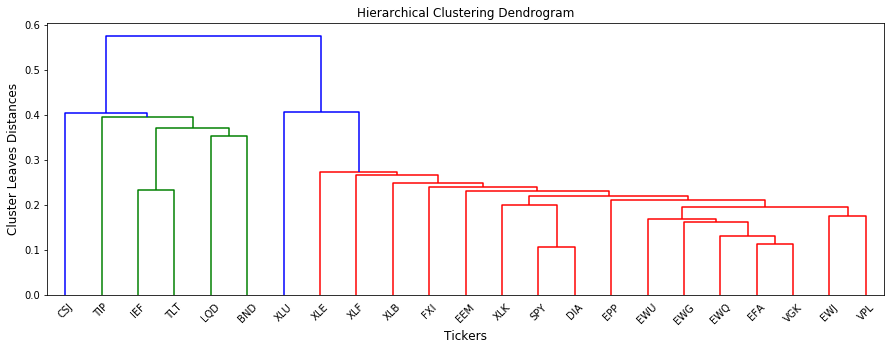

In [121]:
columns = stock_returns_downsampled.columns
plt.figure(figsize = (15, 5))
dendrogram(clusters, labels = columns)
plt.xlabel('Tickers', fontsize = 12)
plt.ylabel('Cluster Leaves Distances', fontsize = 12)
plt.title('Hierarchical Clustering Dendrogram', fontsize = 12)
plt.show()

### (d) Plot the clustered correlation matrix of the N strategies

<Figure size 504x504 with 0 Axes>

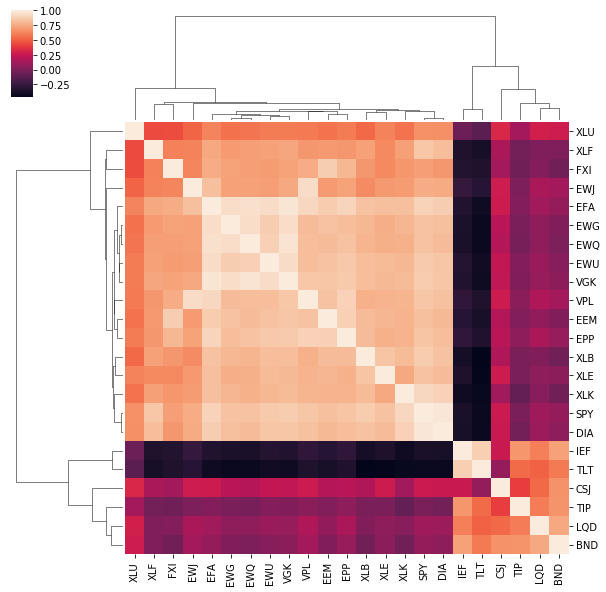

In [126]:
plt.figure(figsize=(7, 7))
sns.clustermap(stock_returns_downsampled.corr())
plt.show()

## Question-16.2

### Using the clustered covariance matrix V from exercise 1:

Each class in mlfinlab's portfolio_optimisation module has an **allocate()** method which takes the raw stock prices, calculates the returns and finds the optimal weights. There is also an option to resample the returns. For our case, we will specify 'W' for weekly resampling.

### (a) Compute the HRP allocations

In [74]:
hrp = HierarchicalRiskParity()
hrp.allocate(asset_prices = stock_prices, resample_returns_by = 'W')
hrp_weights = hrp.weights.sort_values(by = 0, ascending = False, axis = 1)

In [75]:
hrp_weights

,BND,CSJ,TIP,IEF,LQD,XLU,TLT,DIA,XLE,XLB,...,EWJ,XLK,FXI,EEM,VPL,EWG,EFA,EWU,EPP,EWQ
0,0.360859,0.281934,0.119551,0.084645,0.048283,0.018901,0.013247,0.008163,0.007479,0.006193,...,0.004405,0.004337,0.004297,0.004285,0.00427,0.003802,0.003044,0.00252,0.002234,0.002092


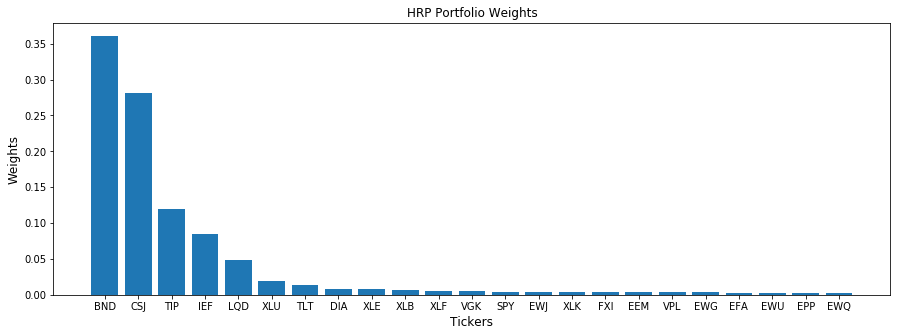

In [122]:
plt.figure(figsize = (15, 5))
plt.bar(hrp_weights.columns, hrp_weights.values[0])
plt.xlabel('Tickers', fontsize = 12)
plt.ylabel('Weights', fontsize = 12)
plt.title('HRP Portfolio Weights', fontsize = 12)
plt.show()

### (b) Compute the CLA allocations

In [13]:
cla = CLA()
cla.allocate(asset_prices = stock_prices, solution = 'cla_turning_points')
cla.weights

,EEM,EWG,TIP,EWJ,EFA,IEF,EWQ,EWU,XLB,XLE,...,XLU,EPP,FXI,VGK,VPL,SPY,TLT,BND,CSJ,DIA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.110223e-16,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.518711e-01,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.882054e-01,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.005331,0.0,0.0,0.0,0.0,4.990372e-01,0.000000,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,2.775558e-17,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5.999018e-02,0.764283,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.491209e-01,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.306990e-01,0.720180,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.594631e-01,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.252529e-01,0.715284,0.0


For HRP and IVP, we get a single set of weights for each asset. However, CLA gives us a dataframe of multiple weights for each stock. Each row of these weight matrix represents a **turning point**. Lets understand what it means.

CLA solves the portfolio optimisation problem with constraints where each weight has a lower and upper bound on itself,

$$l <= W <= u$$

Any weight which lies strictly between these bounds is called a **free weight** while all weights which lie on the bounds (either $W=l$ or $W=u)$are called **bounded weights**. A turning point is a solution to the optimisation problem with different set of free weights from another solution for the problem (this another solution is also a turning point). Due to this, **the CLA algorithm computes multiple turning points (solutions) to the optimisation problem and returns all of these.**

In order to simplify the CLA result, lets calculate the mean weights for each stock across the turning points

In [158]:
cla_weights = cla.weights.mean(axis = 0).reset_index()
cla_weights.index = cla_weights['index']
cla_weights = cla_weights.drop('index', 1)
cla_weights = cla_weights.T
cla_weights = cla_weights.sort_values(by = 0, ascending = False, axis = 1)

In [159]:
cla_weights

index,XLF,CSJ,XLK,BND,EWQ,FXI,EEM,XLU,TLT,SPY,...,LQD,EWG,XLE,XLB,EWU,IEF,EFA,EWJ,TIP,DIA
0,0.308792,0.244416,0.239128,0.172784,0.034287,0.000592,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


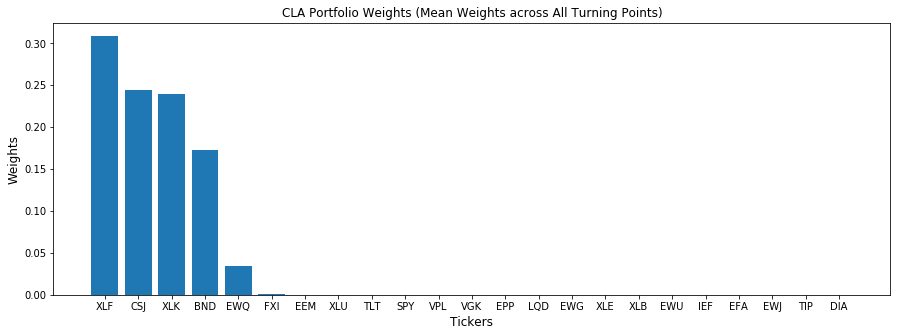

In [160]:
plt.figure(figsize = (15, 5))
plt.bar(cla_weights.columns, cla_weights.values[0])
plt.xlabel('Tickers', fontsize = 12)
plt.ylabel('Weights', fontsize = 12)
plt.title('CLA Portfolio Weights (Mean Weights across All Turning Points)', fontsize = 12)
plt.show()

### Compute the IVP allocations

In [103]:
mvo = MeanVarianceOptimisation()
mvo.allocate(asset_prices = stock_prices, solution = 'inverse_variance', resample_returns_by = 'W')
ivp_weights = mvo.weights.sort_values(by = 0, ascending = False, axis = 1)

In [104]:
ivp_weights

,CSJ,BND,TIP,IEF,LQD,TLT,XLU,DIA,EWJ,SPY,...,EWU,XLB,VGK,EPP,EWQ,XLE,EEM,EWG,FXI,XLF
0,0.274395,0.213997,0.116354,0.110318,0.089768,0.024629,0.017464,0.015954,0.013745,0.013649,...,0.009175,0.008499,0.008493,0.008135,0.0072,0.00691,0.006857,0.006736,0.005896,0.004701


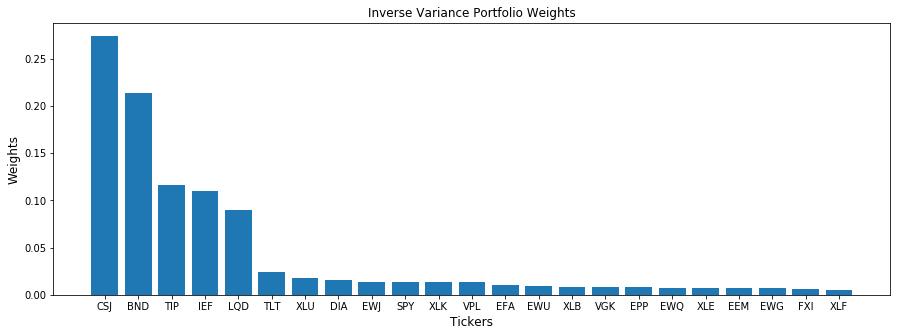

In [123]:
plt.figure(figsize = (15, 5))
plt.bar(ivp_weights.columns, ivp_weights.values[0])
plt.xlabel('Tickers', fontsize = 12)
plt.ylabel('Weights', fontsize = 12)
plt.title('Inverse Variance Portfolio Weights', fontsize = 12)
plt.show()

## Question-16.3

### (a) Perform a spectral decomposition: VW=W$\wedge$

In the spectral decomposition above, **W refers to the eigenvectors matrix while $\wedge$ denotes the eigenvalues matrix - a diagonal matrix with eigenvalues along the diagonal**

In [15]:
N = stock_returns_downsampled.shape[1]

In [31]:
eigenvalues, eigenvectors = np.linalg.eig(V)
eigenvalues_matrix = np.identity(n = N) * eigenvalues

### (b) Form an array $\epsilon$ by drawing N random numbers from U[0, 1] distribution

In [32]:
epsilon = np.random.uniform(low = 0, high = 1, size = N)
epsilon

array([0.36636184, 0.45606998, 0.78517596, 0.19967378, 0.51423444,
       0.59241457, 0.04645041, 0.60754485, 0.17052412, 0.06505159,
       0.94888554, 0.96563203, 0.80839735, 0.30461377, 0.09767211,
       0.68423303, 0.44015249, 0.12203823, 0.49517691, 0.03438852,
       0.9093204 , 0.25877998, 0.66252228])

### (c) Form an NxN matrix $\wedge^{'}$, where $\wedge^{'}_{n,n}=N\epsilon_{n}\wedge_{n,n}(\sum\epsilon_{n})^{-1}, n=1....N$

In [18]:
eigenvalues_matrix_modified = (N * epsilon * eigenvalues_matrix)/np.sum(epsilon)

### (d) Compute $V^{'}=W\wedge^{'}W^{-1}$

In [128]:
V_modified = eigenvectors @ eigenvalues_matrix_modified @ np.linalg.inv(eigenvectors)
V_modified = pd.DataFrame(V_modified)
V_modified.columns = V.columns
V_modified.index = V.index

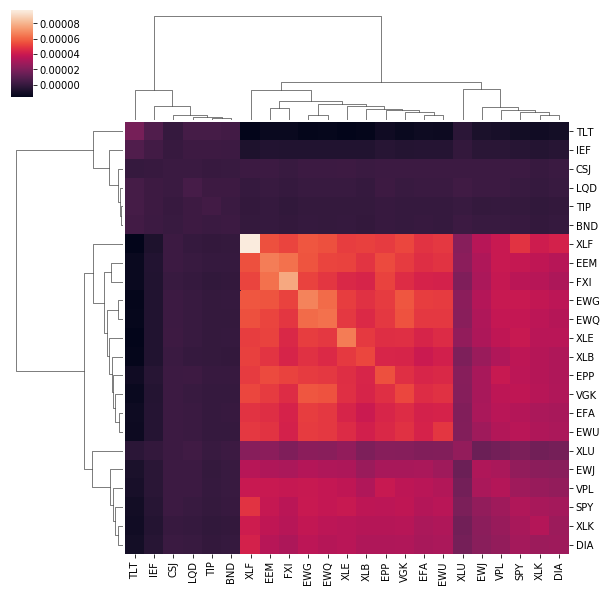

In [129]:
sns.clustermap(V)
plt.show()

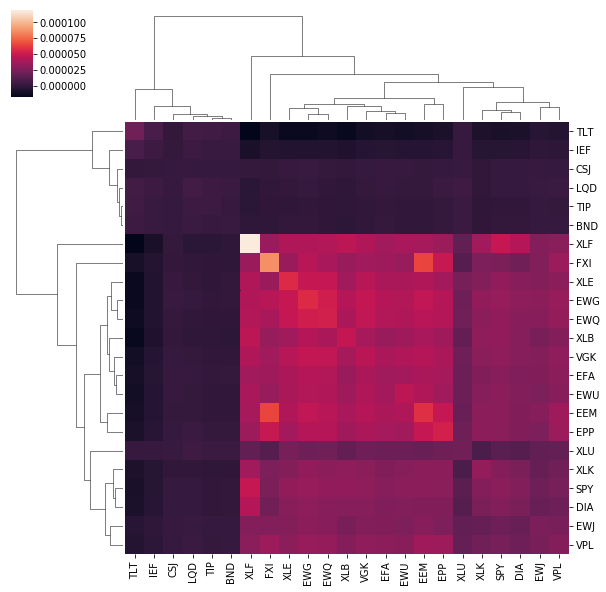

In [130]:
sns.clustermap(V_modified)
plt.show()

### (e) Repeat exercise 2, this time using $V^{'}$ as covariance matrix. What allocation method has been most impacted by the re-scaling of spectral variances?

In each of the 3 sections below, we copy the code for the three algorithms in our package. The only change is that wherever **covariance matrix is calculated from the data using asset_returns.cov(), we will use V_modified.** Everything else remains the same.

### (i) HRP

In [88]:
hrp_modified = HierarchicalRiskParityModified()
hrp_modified.allocate(asset_prices = stock_prices, resample_returns_by = 'W', covariance = V_modified)
hrp_modified_weights = hrp_modified.weights.sort_values(by = 0, ascending = False, axis = 1)

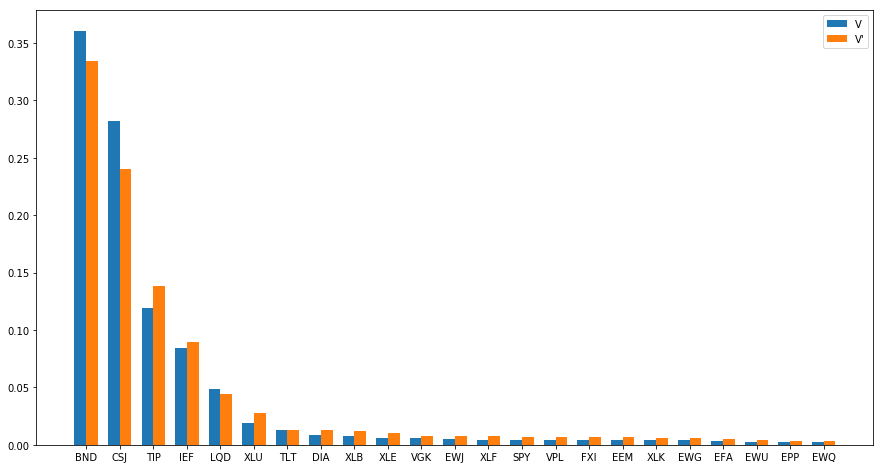

In [138]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
index = np.arange(N)
width = 0.35
ax.bar(index, hrp_weights.values[0], width, label = "V")
ax.bar(index + width, hrp_modified_weights.values[0], width, label = "V'")
ax.set_xticks(index + width / 2)
ax.set_xticklabels(hrp_modified_weights.columns)
plt.legend()
plt.show()

### (ii) CLA

In [25]:
cla_modified = CLAModified()
cla_modified.allocate(asset_prices = stock_prices, solution = 'cla_turning_points', covariance = V_modified)

In [162]:
cla_modified_weights = cla_modified.weights.mean(axis = 0).reset_index()
cla_modified_weights.index = cla_modified_weights['index']
cla_modified_weights = cla_modified_weights.drop('index', 1)
cla_modified_weights = cla_modified_weights.T
cla_modified_weights = cla_modified_weights.sort_values(by = 0, ascending = False, axis = 1)

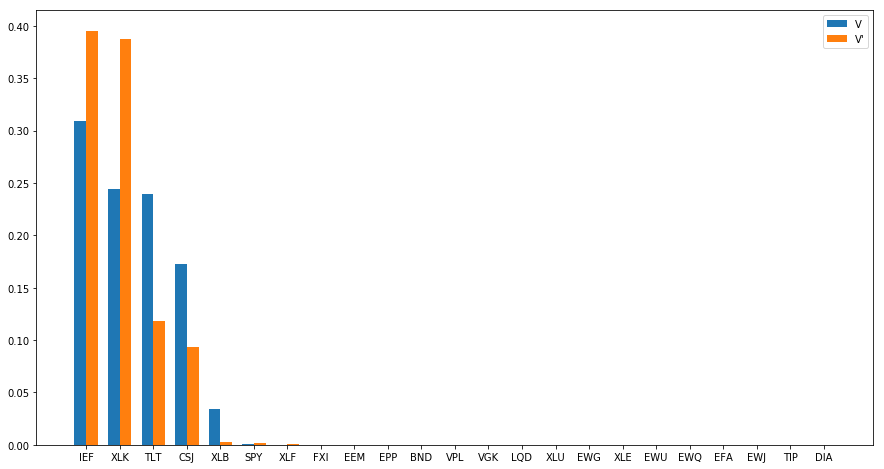

In [163]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
index = np.arange(N)
width = 0.35
ax.bar(index, cla_weights.values[0], width, label = 'V')
ax.bar(index + width, cla_modified_weights.values[0], width, label = "V'")
ax.set_xticks(index + width / 2)
ax.set_xticklabels(cla_modified_weights.columns)
plt.legend()
plt.show()

### (iii) IVP

In [106]:
mvo_modified = MeanVarianceOptimisationModified()
mvo_modified.allocate(asset_prices = stock_prices, covariance = V_modified, solution = 'inverse_variance', resample_returns_by = 'W')
ivp_modified_weights = mvo_modified.weights.sort_values(by = 0, ascending = False, axis = 1)

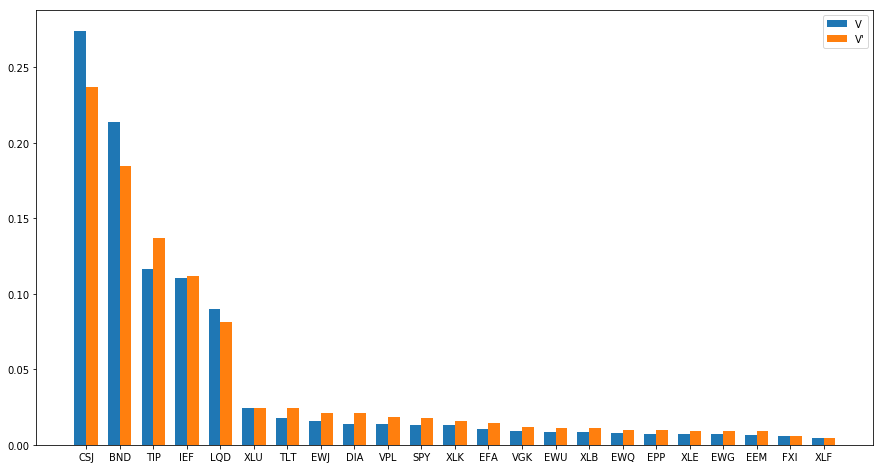

In [139]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
index = np.arange(N)
width = 0.35
ax.bar(index, ivp_weights.values[0], width, label = 'V')
ax.bar(index + width, ivp_modified_weights.values[0], width, label = "V'")
ax.set_xticks(index + width / 2)
ax.set_xticklabels(ivp_modified_weights.columns)
plt.legend()
plt.show()